In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 80

train = pd.read_csv('./trainWithQualE.csv')
test = pd.read_csv('./testWithQualE.csv')

In [2]:
train[train.isnull().any(axis=1)]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, MSSubClass_E, MSZoning_E, Street_E, Alley_E, LotShape_E, LandContour_E, Utilities_E, LotConfig_E, LandSlope_E, Neighborhood_E, Condition1_E, Condition2_E, BldgType_E, HouseStyle_E, RoofStyle_E, RoofMatl_E, Exterior1st_E, Exterior2nd_E, MasVnrType_E, ...]
Index: []

[0 rows x 126 columns]

In [3]:
test[test.isnull().any(axis=1)]

Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, MSSubClass_E, MSZoning_E, Street_E, Alley_E, LotShape_E, LandContour_E, Utilities_E, LotConfig_E, LandSlope_E, Neighborhood_E, Condition1_E, Condition2_E, BldgType_E, HouseStyle_E, RoofStyle_E, RoofMatl_E, Exterior1st_E, Exterior2nd_E, MasVnrType_E, ExterQual_E, ...]
Index: []

[0 rows x 125 columns]

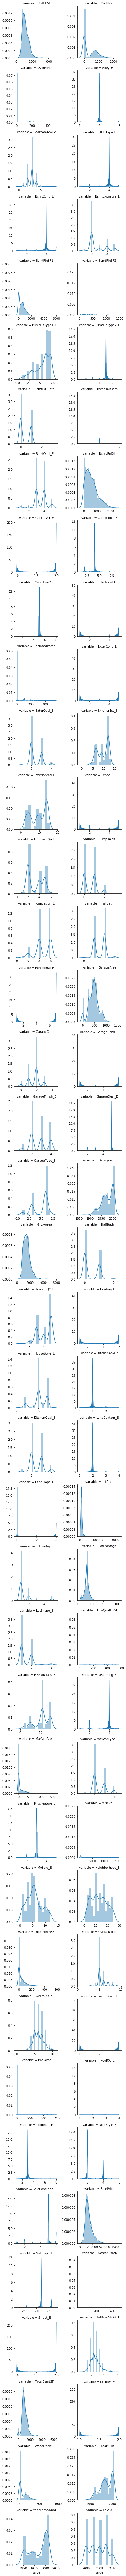

In [4]:
# Plot the distributions of all the quantitative variables including SalePrice

def quantVarDistPlot(frame):
    quantitative = [f for f in frame.columns if frame.dtypes[f] != 'object']
    quantitative.remove('Id')
    f = pd.melt(frame, value_vars=quantitative)
    f=f.sort_values('variable')
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex = False, sharey = False )
    g = g.map(sns.distplot, "value")
    
quantVarDistPlot(train)

In [5]:
# Order the categories of each of the qualitative features by the median of SalePrice for that category.

def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmedian'] = frame[[feature, 'SalePrice']].groupby(feature).median()['SalePrice']
    ordering = ordering.sort_values('spmedian')
    ordering['ordering'] = range(1,ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    return(ordering)

def featureOrdering(frame):
    featureOrdering = {}
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    for feature in qualitative:
        ordering = encode(frame,feature)
        featureOrdering[feature] = ordering
    return featureOrdering
    
trainFO = featureOrdering(train)

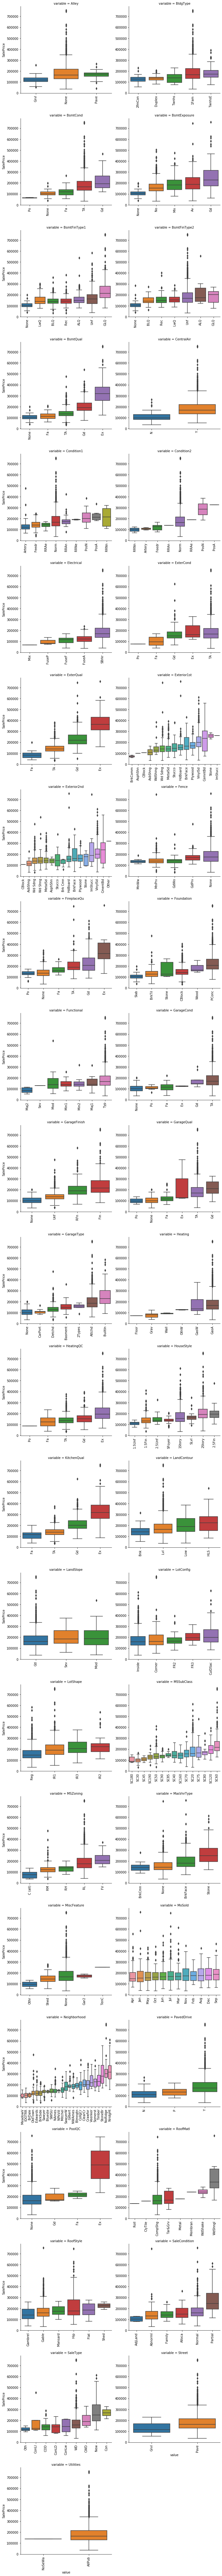

In [6]:
# Make boxplot to check the distribution of SalePrice for each of the different categories
# of the qualitative variables. 

# Remember that a box plot shows minimum, maximum, median, first quartile, and third 
# quartile. If a qualitiative feature is predictive, then the boxes corresponding to 
# different categories should be at different heights -- like neighborhood.

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

def qualBoxPlot(frame, id_var, featureOrdering):
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    f = pd.melt(frame, id_vars=[id_var], value_vars=qualitative)
    f['ordering'] = f.apply(lambda row: featureOrdering[row['variable']][row['value']], axis=1)
    f=f.sort_values(['variable', 'ordering'])
    
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex = False, sharey = False, height=5)
    g = g.map(boxplot, "value", id_var)
    
qualBoxPlot(train, 'SalePrice', trainFO)

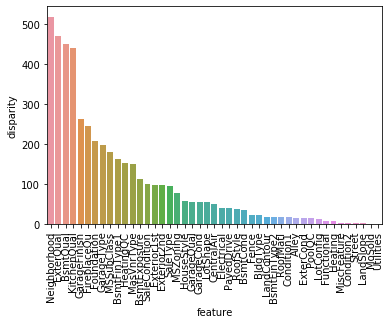

In [7]:
# For each feature, ANOVA tests the hypothesis that the class means are equal. 
# The output of ANOVA is the measure f of an F-statistic and a p-value.
#
# The p-value is the probability that the F-statistic would exceed the observed
# value f if the null hypothesis is true. The higher the p value, the more likely
# that the class means are equal.
#
# This is why we plot log of the inverse p-values. The closer the p-value is to 1, 
# more likely the null hypothesis that the class means are equal, the closer the 
# log of the inverse p-value is to zero. On the other hand, the closer the p-value
# is to 0, the less likely the null hypothesis that the class means are equal,
# the larger the log of the inverse p-value is.
#
# The features with the larger log of inverse p values are the ones where different
# classes have the most effect on the sale price.

def anova(frame):
    anv = pd.DataFrame()
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s=frame[frame[c]==cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')
        
def anovaDisparity(frame):
    a=anova(frame)
    a['disparity'] = np.log(1./a['pval'].values)
    sns.barplot(data=a, x='feature', y='disparity')
    x=plt.xticks(rotation=90)
    
anovaDisparity(train)    

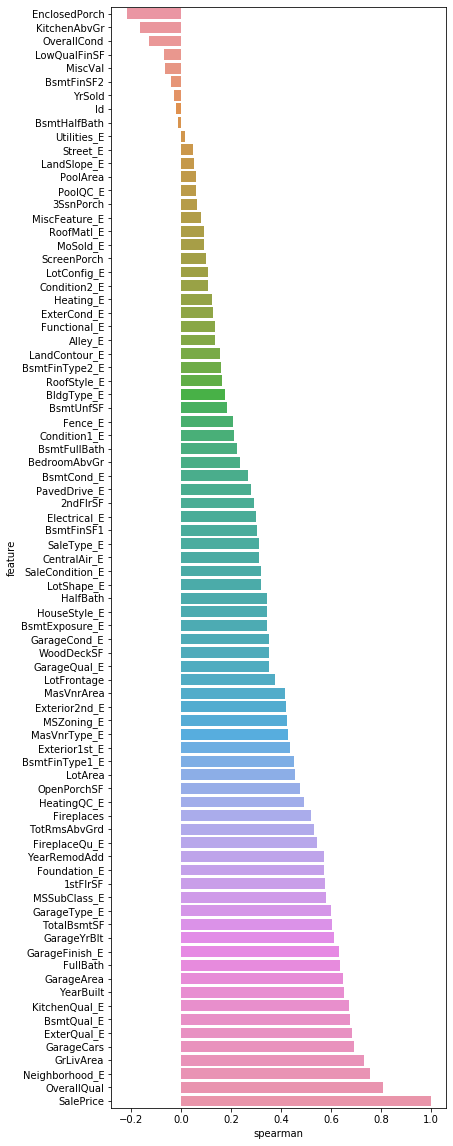

In [8]:
# Make a bar graph of the Spearman correlation coefficient of each qualitative encoded
# variable with SalePrice.

# YrSold correlates negatively with SalePrice because the data includes GFC.

def spearman(frame, target_col):
    features = [f for f in frame.columns if frame.dtypes[f] != 'object']
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target_col], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')

spearman(train, 'SalePrice')

Notable Correlations:
OverallQual ,  SalePrice ,  0.7909816005838047
YearBuilt ,  GarageYrBlt ,  0.8451406660104657
TotalBsmtSF ,  1stFlrSF ,  0.8195299750050355
GrLivArea ,  TotRmsAbvGrd ,  0.8254893743088377
GrLivArea ,  SalePrice ,  0.7086244776126511
GarageCars ,  GarageArea ,  0.8824754142814603


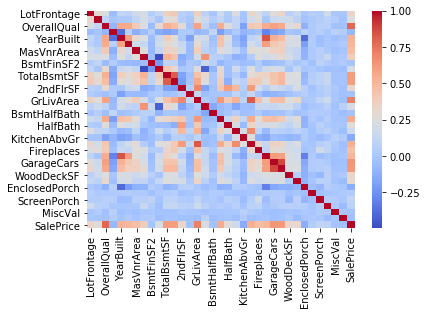

In [9]:
# Make heatmaps of Pearson correlation coefficient of quantitative variables plus SalePrice versus themselves

def varPearsonCorrHeatMap(frame, variables, threshold): 
    corr = frame[variables].corr()
    sns.heatmap(corr, cmap="coolwarm")

    print('Notable Correlations:')
    for i in range(len(variables)):
        for j in range(i+1, len(variables)):
            if corr.iloc[i][j] > threshold:
                print(variables[i], ", ", variables[j], ", ", corr.iloc[i][j])

pureQuantVariables = [f for f in train.columns if train.dtypes[f] != 'object' and not f.endswith('_E')]
pureQuantVariables.remove('Id')
varPearsonCorrHeatMap(train, pureQuantVariables, 0.7)

Notable Correlations:
Exterior1st_E ,  Exterior2nd_E ,  0.9022538394261372
ExterQual_E ,  KitchenQual_E ,  0.7161221955032785
GarageQual_E ,  GarageCond_E ,  0.898577899419135


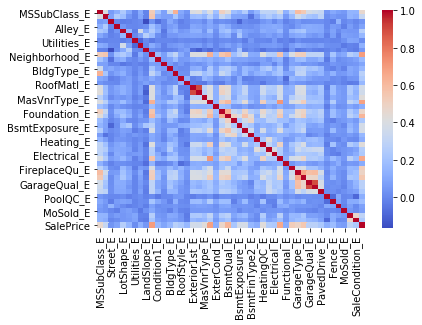

In [10]:
QualEncodedVariables = [f for f in train.columns if train.dtypes[f] != 'object' and f.endswith('_E')]
varPearsonCorrHeatMap(train, QualEncodedVariables + ['SalePrice'], 0.7)

Notable Correlations
OverallQual ,  ExterQual_E ,  0.7262784907641432
OverallQual ,  SalePrice ,  0.7909816005838047
YearBuilt ,  Foundation_E ,  0.7269153014537947
GrLivArea ,  SalePrice ,  0.7086244776126522
Fireplaces ,  FireplaceQu_E ,  0.812340286765963
PoolArea ,  PoolQC_E ,  0.8842503024390972


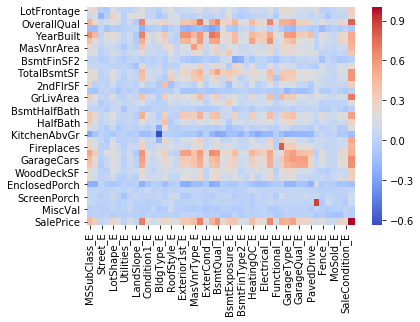

In [11]:
# Make heatmaps of Pearson correlation coefficients of quantitative variables plus SalePrice versus 
# qualitative variables plus SalePrice

def xyVarPearsonCorrHeatMap(frame, xVariables, yVariables, threshold):
    corr=pd.DataFrame(
        np.zeros([len(xVariables), len(yVariables)]),
        index=xVariables,
        columns=yVariables
    )

    print('Notable Correlations')
    for q1 in xVariables:
        for q2 in yVariables:
            corr.loc[q1,q2] = frame[q1].corr(frame[q2])
            if corr.loc[q1,q2] > threshold and q1 != q2:
                print(q1, ", ", q2, ", ", corr.loc[q1][q2])
    sns.heatmap(corr, cmap="coolwarm")
    
xyVarPearsonCorrHeatMap(train, pureQuantVariables, QualEncodedVariables+['SalePrice'], 0.7)

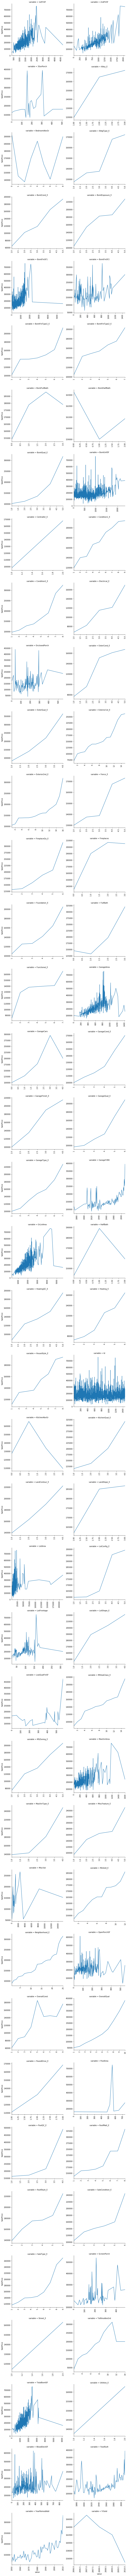

In [12]:
# Plot all quantitative and qualitative encoded features against SalePrice

def pairplot(x,y,**kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'time':x, 'val':y})
    ts = ts.groupby('time').median()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)

def pairPlotFeaturesTarget(frame, target_col):
    features = [f for f in frame.columns if frame.dtypes[f] != 'object']
    features.remove('SalePrice')
    f = pd.melt(frame, id_vars=[target_col], value_vars=features)
    f = f.sort_values('variable')
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, height=5)
    g = g.map(pairplot, "value", target_col)
    
pairPlotFeaturesTarget(train, 'SalePrice')    

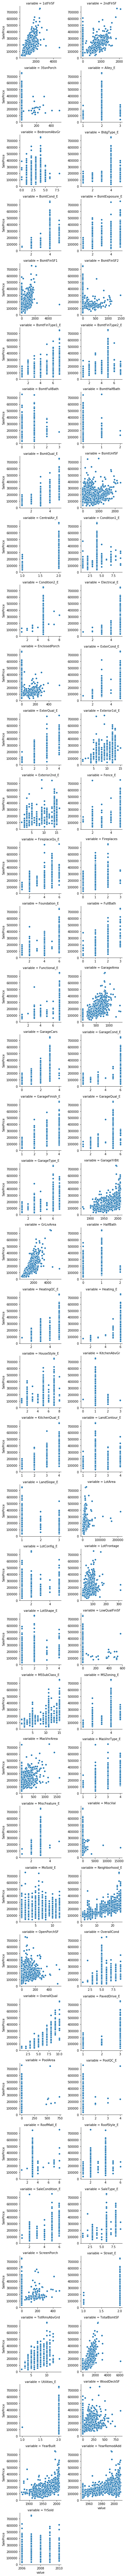

In [13]:
# Check for outliers using scatterplots

def outlierScatterplotCheck(frame, id_var):
    quantitative = [f for f in frame.columns if frame.dtypes[f] != 'object']
    quantitative.remove('Id')
    quantitative.remove('SalePrice')
    f = pd.melt(frame, id_vars=[id_var], value_vars=quantitative)
    f = f.sort_values('variable')
    g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey = False )
    g = g.map(sns.scatterplot, "value", id_var)
    
outlierScatterplotCheck(train, 'SalePrice')

In [14]:
# Find outliers using the median absolute deviation method

def mad_method(df, quantCols, threshold):
    df = df[quantCols]
    med = np.median(df, axis=0)
    mad = np.abs(stats.median_absolute_deviation(df))
    outlierDict = {}
    for i in range(len(quantCols)):
        outliers = []
        for j,v in enumerate(df.loc[:,quantCols[i]]):
            t = ( v - med[i] ) / mad[i]
            if t > threshold:
                outliers.append(j)
        outlierDict[quantCols[i]] = outliers
    return outlierDict

outlierCols = ['1stFlrSF', 'BsmtFinSF1','GrLivArea', 'TotalBsmtSF']
outlierDict = mad_method(train, outlierCols, 5)
print(outlierDict)

{'1stFlrSF': [496, 523, 1024, 1298], 'BsmtFinSF1': [1298], 'GrLivArea': [523, 691, 1182, 1298], 'TotalBsmtSF': [332, 440, 496, 523, 1298]}


In [15]:
# Inspect the outliers

def inspectOutliers(outlierDict):
    bigList = []
    for outlierlist in outlierDict.values():
        bigList = bigList + outlierlist
    bigSet = list(set(bigList))
    bigSet.sort()
    return bigSet

outliers = inspectOutliers(outlierDict)
train.iloc[outliers][outlierCols + ['SalePrice']]

1stFlrSF  BsmtFinSF1  GrLivArea  TotalBsmtSF  SalePrice
332       1629        1124       1629         3206     284000
440       2402        1767       2402         3094     555000
496       3228        1231       3228         3200     430000
523       3138        2260       4676         3138     184750
691       2444        1455       4316         2444     755000
1024      2898        1165       2898         1565     287000
1182      2411        2096       4476         2396     745000
1298      4692        5644       5642         6110     160000

In [16]:
train['Neighborhood'].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [17]:
test['Neighborhood'].value_counts()

NAmes      218
OldTown    126
CollgCr    117
Somerst     96
Edwards     94
NridgHt     89
Gilbert     86
Sawyer      77
SawyerW     66
Mitchel     65
NWAmes      58
IDOTRR      56
Crawfor     52
BrkSide     50
Timber      34
NoRidge     30
StoneBr     26
SWISU       23
MeadowV     20
ClearCr     16
NPkVill     14
BrDale      14
Veenker     13
Blmngtn     11
Blueste      8
Name: Neighborhood, dtype: int64

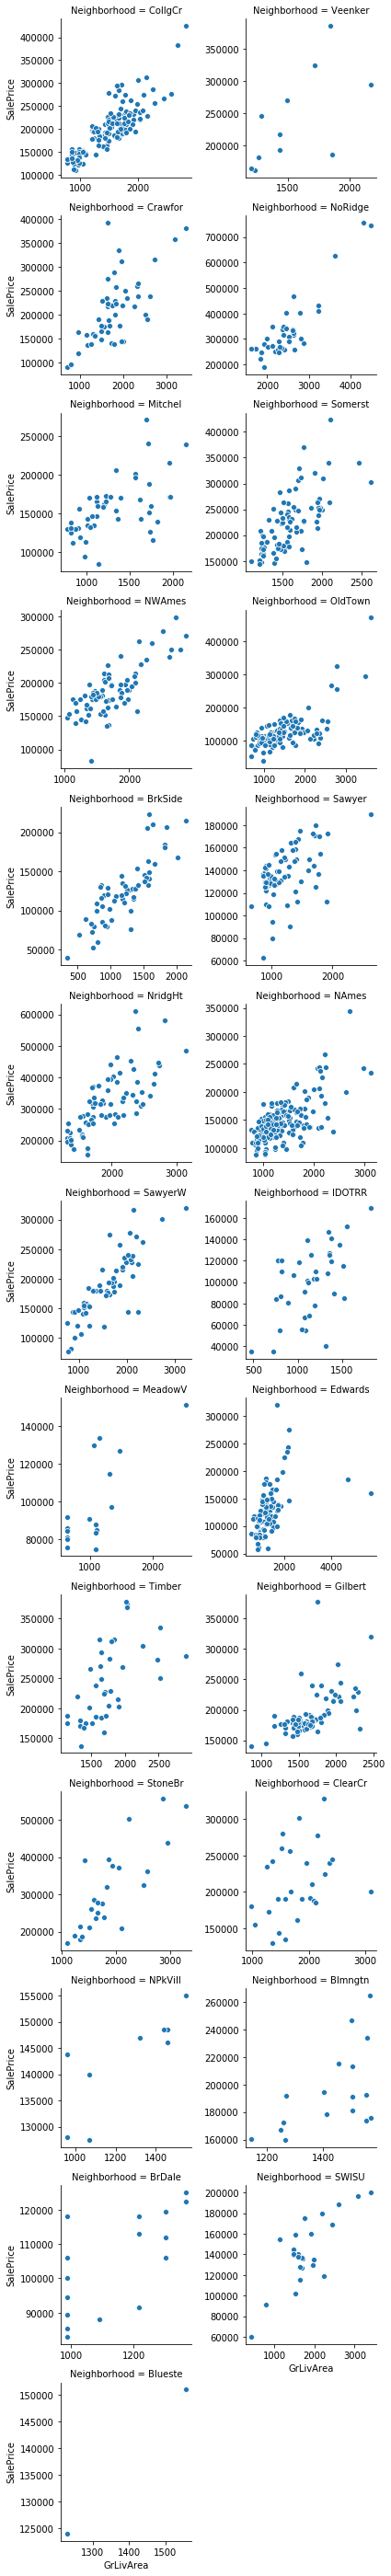

In [18]:
def NhbdFeatureSalePriceScatter(frame, columns):
    f = frame[columns]
    g = sns.FacetGrid(f, col=columns[0], col_wrap=2, sharex=False, sharey = False )
    g = g.map(sns.scatterplot, columns[1], columns[2])
    
NhbdFeatureSalePriceScatter(train, ['Neighborhood', 'GrLivArea', 'SalePrice'])

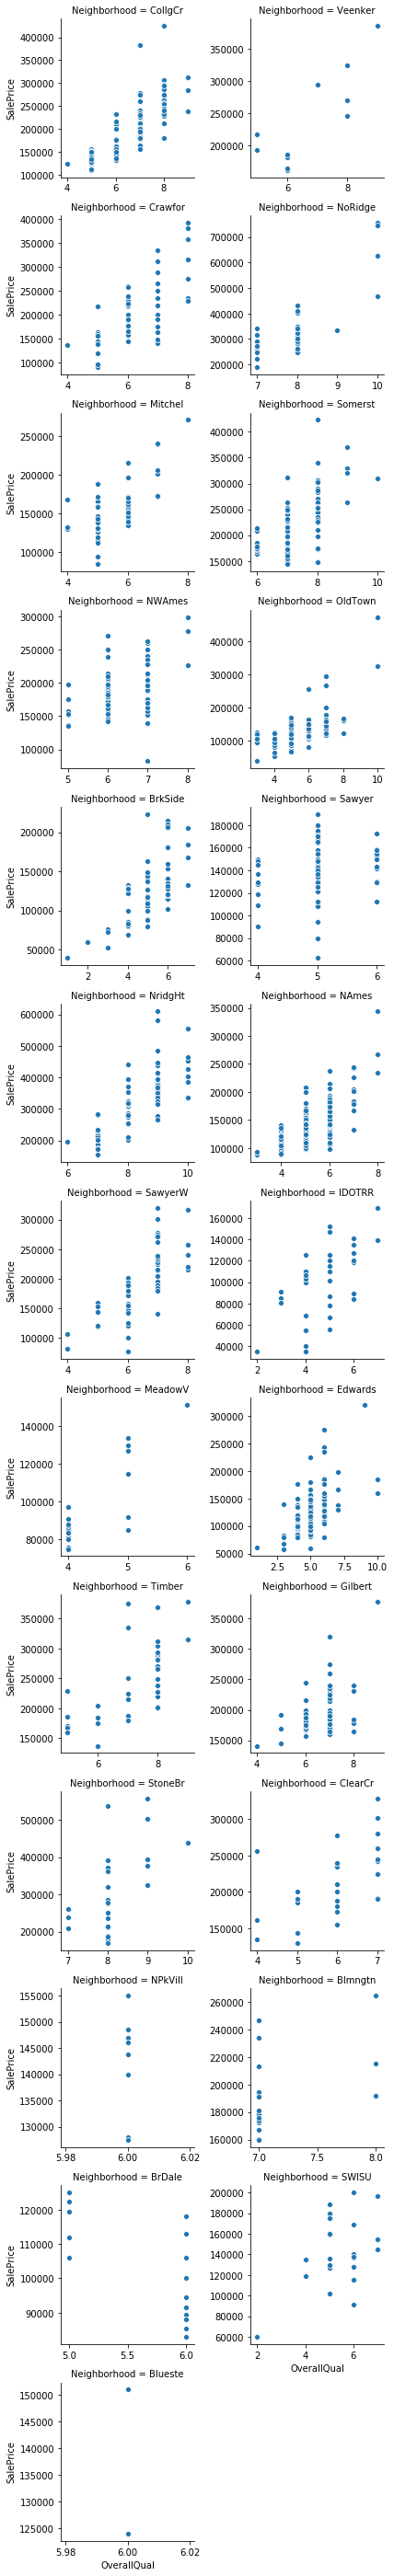

In [19]:
NhbdFeatureSalePriceScatter(train, ['Neighborhood', 'OverallQual', 'SalePrice'])

In [20]:
def NbhdPricePerSquareFoot(frame):
    nbhds = frame['Neighborhood'].unique()
    df = pd.DataFrame()
    df['Neighborhood'] = nbhds
    Coeff = []
    Intercept = []
    Score = []
    for n in nbhds:
        df2 = frame.loc[frame['Neighborhood'] == n]
        X = df2['GrLivArea'].to_numpy().reshape(-1,1)
        y = df2['SalePrice'].to_numpy().reshape(-1,1)
        reg = linear_model.LinearRegression().fit(X,y)
        Coeff.append(reg.coef_[0][0])
        Intercept.append(reg.intercept_[0])
        Score.append(reg.score(X,y))
    df['Coeff'] = Coeff
    df['Intercept'] = Intercept
    df['Score'] = Score
    df = df.sort_values('Coeff', ascending=False)
    return df

In [21]:
NbhdPPSF = NbhdPricePerSquareFoot(train)
NbhdPPSF.head(n=25)

Neighborhood       Coeff      Intercept     Score
3       NoRidge  181.882031 -121020.082658  0.786662
10      NridgHt  169.179486   -7868.482420  0.562248
18      StoneBr  160.549839    8813.008913  0.657894
1       Veenker  147.571375   11566.472848  0.409932
5       Somerst  131.858211   14848.271593  0.479235
21      Blmngtn  125.871850   15133.284975  0.327478
0       CollgCr  103.124849   45289.434700  0.747407
16       Timber   99.530624   68131.716366  0.361230
12      SawyerW   89.711257   43464.821378  0.670564
8       BrkSide   87.162533   19971.513795  0.697520
2       Crawfor   85.524725   57397.958089  0.457344
24      Blueste   82.568807   22522.935780  1.000000
17      Gilbert   70.224153   77594.448967  0.337422
6        NWAmes   68.316750   71013.697902  0.585539
13       IDOTRR   65.992961   24740.202510  0.315098
7       OldTown   63.446500   34341.886898  0.483366
22       BrDale   61.704412   33954.037079  0.450219
4       Mitchel   55.777330   84082.874601  0.333172
11        NAmes   54.315863   74676.401537  0.461097
23        SWISU   40.894231   68931.035607  0.628350
14      MeadowV   37.340981   59034.568075  0.564419
19      ClearCr   34.390222  151072.027791  0.102330
9        Sawyer   34.359938   95041.167301  0.280823
20      NPkVill   31.426846  103316.606041  0.633621
15      Edwards   29.750302   88353.104780  0.203518

In [22]:
ExpensiveNbhds = NbhdPPSF.loc[NbhdPPSF['Coeff'] > 125]['Neighborhood'].to_list()
Expensive = train.loc[train['Neighborhood'].isin(ExpensiveNbhds)]
print(Expensive.shape)

(257, 126)


In [23]:
MidNbhds = NbhdPPSF.loc[(NbhdPPSF['Coeff'] < 125) & (NbhdPPSF['Coeff'] > 80)]['Neighborhood'].to_list() + ['ClearCr']
Mid = train.loc[train['Neighborhood'].isin(MidNbhds)]
print(Mid.shape)

(386, 126)


In [24]:
CheapNbhds = NbhdPPSF.loc[NbhdPPSF['Coeff'] < 80]['Neighborhood'].to_list()
CheapNbhds.remove('ClearCr')
Cheap = train.loc[train['Neighborhood'].isin(CheapNbhds)]
print(Cheap.shape)

(817, 126)


In [25]:
print(Expensive.shape[0] + Mid.shape[0] + Cheap.shape[0])

1460


In [26]:
expensiveFO = featureOrdering(Expensive)

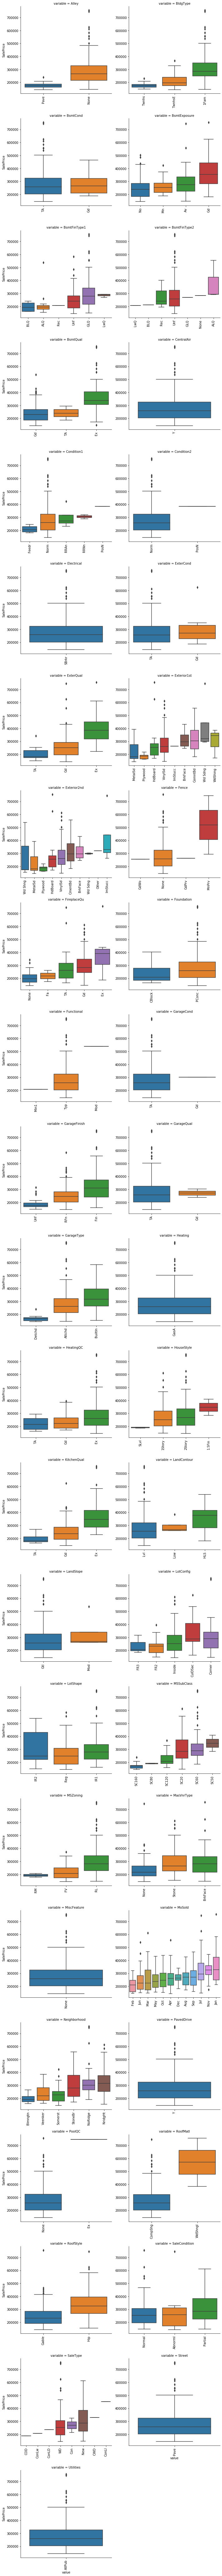

In [27]:
qualBoxPlot(Expensive, 'SalePrice', expensiveFO)

/home/seasnake/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3233: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / dfbn


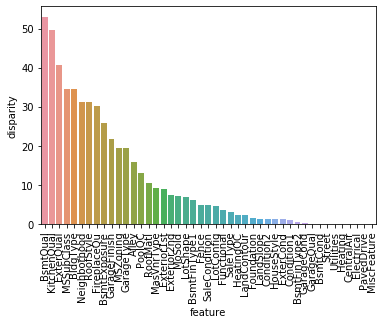

In [28]:
anovaDisparity(Expensive)    

In [29]:
midFO = featureOrdering(Mid)

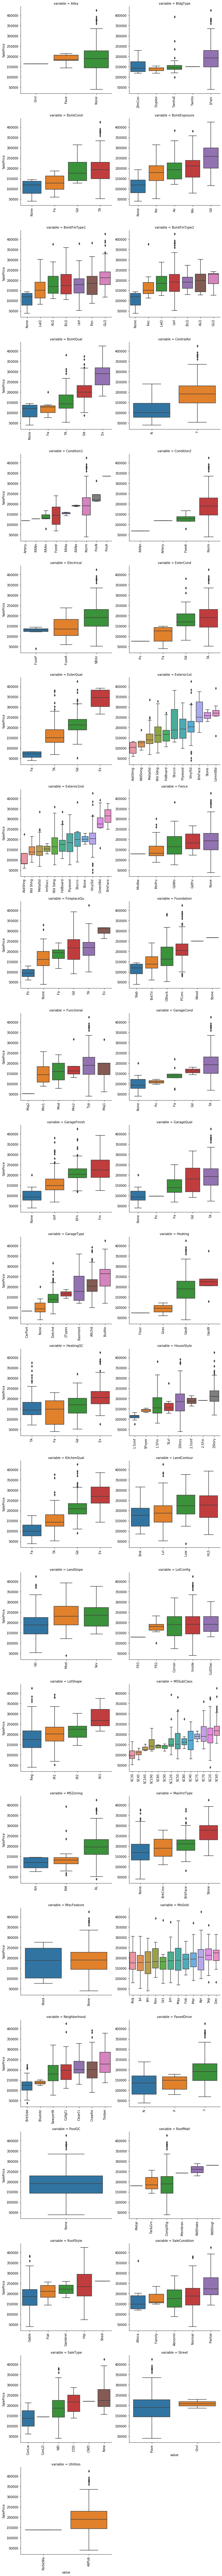

In [30]:
qualBoxPlot(Mid, 'SalePrice', midFO)

/home/seasnake/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3233: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / dfbn


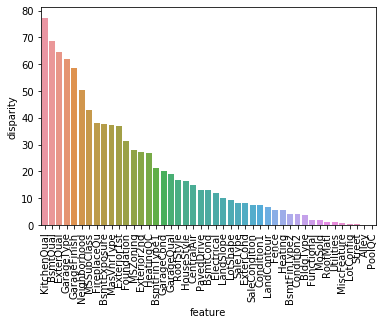

In [31]:
anovaDisparity(Mid)

In [32]:
cheapFO = featureOrdering(Cheap)

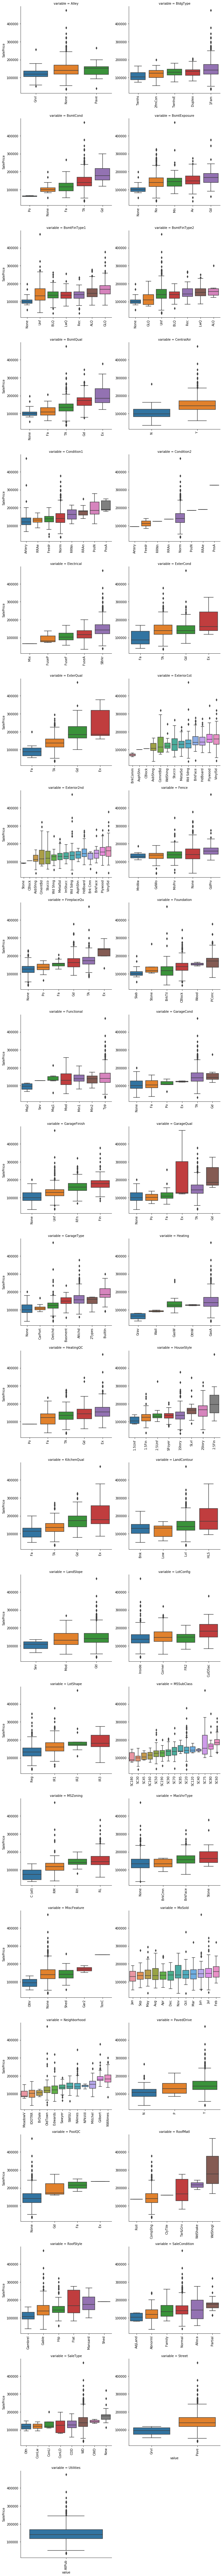

In [33]:
qualBoxPlot(Cheap, 'SalePrice', cheapFO)

/home/seasnake/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3233: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / dfbn


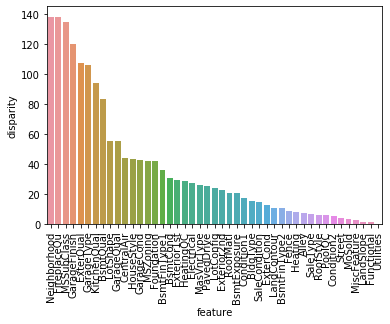

In [34]:
anovaDisparity(Cheap)

In [35]:
Expensive = Expensive.drop(columns=QualEncodedVariables)
print(Expensive.shape)
Expensive.head()

(257, 81)


Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1    2       SC20       RL         80.0     9600   Pave  None      Reg   
4    5       SC60       RL         84.0    14260   Pave  None      IR1   
6    7       SC20       RL         75.0    10084   Pave  None      Reg   
11  12       SC60       RL         85.0    11924   Pave  None      IR1   
20  21       SC60       RL        101.0    14215   Pave  None      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
4          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
6          Lvl    AllPub    Inside       Gtl      Somerst       Norm   
11         Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
20         Lvl    AllPub    Corner       Gtl      NridgHt       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1        Norm     1Fam     1Story            6            8       1976   
4        Norm     1Fam     2Story            8            5       2000   
6        Norm     1Fam     1Story            8            5       2004   
11       Norm     1Fam     2Story            9            5       2005   
20       Norm     1Fam     2Story            8            5       2005   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1           1976     Gable  CompShg     MetalSd     MetalSd       None   
4           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
6           2005     Gable  CompShg     VinylSd     VinylSd      Stone   
11          2006       Hip  CompShg     WdShing     Wd Shng      Stone   
20          2006     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
1          0.0        TA        TA     CBlock       Gd       TA           Gd   
4        350.0        Gd        TA      PConc       Gd       TA           Av   
6        186.0        Gd        TA      PConc       Ex       TA           Av   
11       286.0        Ex        TA      PConc       Ex       TA           No   
20       380.0        Gd        TA      PConc       Ex       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
1           ALQ         978          Unf           0        284         1262   
4           GLQ         655          Unf           0        490         1145   
6           GLQ        1369          Unf           0        317         1686   
11          GLQ         998          Unf           0        177         1175   
20          Unf           0          Unf           0       1158         1158   

   Heating  ... CentralAir Electrical 1stFlrSF  2ndFlrSF  LowQualFinSF  \
1     GasA  ...          Y      SBrkr     1262         0             0   
4     GasA  ...          Y      SBrkr     1145      1053             0   
6     GasA  ...          Y      SBrkr     1694         0             0   
11    GasA  ...          Y      SBrkr     1182      1142             0   
20    GasA  ...          Y      SBrkr     1158      1218             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
1        1262             0             1         2         0             3   
4        2198             1             0         2         1             4   
6        1694             1             0         2         0             3   
11       2324             1             0         3         0             4   
20       2376             0             0         3         1             4   

    KitchenAbvGr  KitchenQual TotRmsAbvGrd  Functional Fireplaces  \
1              1           TA            6         Typ          1   
4              1           Gd            9         Typ          1   
6              1           Gd            7         Typ          1   
11             1           Ex           11         Typ          2   
20       

In [36]:
# Re-encode qualitative variables for Expensive, Mid, and Cheap 

def qualitativeEncode(frame, fo):
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    for feature in qualitative:
        frame[feature + "_E"] = frame.apply(
            lambda row: fo[feature][row[feature]], axis=1)
    return frame    

In [37]:
expensiveWithQualE = Expensive.copy()
expensiveWithQualE = qualitativeEncode(expensiveWithQualE, expensiveFO)
expensiveWithQualE.head()    

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1    2       SC20       RL         80.0     9600   Pave  None      Reg   
4    5       SC60       RL         84.0    14260   Pave  None      IR1   
6    7       SC20       RL         75.0    10084   Pave  None      Reg   
11  12       SC60       RL         85.0    11924   Pave  None      IR1   
20  21       SC60       RL        101.0    14215   Pave  None      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
1          Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
4          Lvl    AllPub       FR2       Gtl      NoRidge       Norm   
6          Lvl    AllPub    Inside       Gtl      Somerst       Norm   
11         Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
20         Lvl    AllPub    Corner       Gtl      NridgHt       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
1        Norm     1Fam     1Story            6            8       1976   
4        Norm     1Fam     2Story            8            5       2000   
6        Norm     1Fam     1Story            8            5       2004   
11       Norm     1Fam     2Story            9            5       2005   
20       Norm     1Fam     2Story            8            5       2005   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
1           1976     Gable  CompShg     MetalSd     MetalSd       None   
4           2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   
6           2005     Gable  CompShg     VinylSd     VinylSd      Stone   
11          2006       Hip  CompShg     WdShing     Wd Shng      Stone   
20          2006     Gable  CompShg     VinylSd     VinylSd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
1          0.0        TA        TA     CBlock       Gd       TA           Gd   
4        350.0        Gd        TA      PConc       Gd       TA           Av   
6        186.0        Gd        TA      PConc       Ex       TA           Av   
11       286.0        Ex        TA      PConc       Ex       TA           No   
20       380.0        Gd        TA      PConc       Ex       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
1           ALQ         978          Unf           0        284         1262   
4           GLQ         655          Unf           0        490         1145   
6           GLQ        1369          Unf           0        317         1686   
11          GLQ         998          Unf           0        177         1175   
20          Unf           0          Unf           0       1158         1158   

   Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
1     GasA  ...             1           1           2            1   
4     GasA  ...             1           1           2            1   
6     GasA  ...             1           1           3            1   
11    GasA  ...             1           1           3            1   
20    GasA  ...             1           1           5            1   

    Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
1                2             1             1           3             2   
4                5             2             1           3             3   
6                3             2             1           3             2   
11               6             2             1           3             3   
20               6             2             1           3             3   

    RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
1             1           1              1              2            1   
4             1           1              4              5            3   
6             1           1              4              5            2   
11            2           1              9              1            2   
20            1           

In [38]:
Mid = Mid.drop(columns=QualEncodedVariables)
print(Mid.shape)
Mid.head()

(386, 81)


Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0    1       SC60       RL         65.0     8450   Pave  None      Reg   
2    3       SC60       RL         68.0    11250   Pave  None      IR1   
3    4       SC70       RL         60.0     9550   Pave  None      IR1   
9   10      SC190       RL         50.0     7420   Pave  None      Reg   
13  14       SC20       RL         91.0    10652   Pave  None      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
9          Lvl    AllPub    Corner       Gtl      BrkSide     Artery   
13         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     2Story            7            5       2001   
3        Norm     1Fam     2Story            7            5       1915   
9      Artery   2fmCon     1.5Unf            5            6       1939   
13       Norm     1Fam     1Story            7            5       2006   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
9           1950     Gable  CompShg     MetalSd     MetalSd       None   
13          2007     Gable  CompShg     VinylSd     VinylSd      Stone   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0        196.0        Gd        TA      PConc       Gd       TA           No   
2        162.0        Gd        TA      PConc       Gd       TA           Mn   
3          0.0        TA        TA     BrkTil       TA       Gd           No   
9          0.0        TA        TA     BrkTil       TA       TA           No   
13       306.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0           GLQ         706          Unf           0        150          856   
2           GLQ         486          Unf           0        434          920   
3           ALQ         216          Unf           0        540          756   
9           GLQ         851          Unf           0        140          991   
13          Unf           0          Unf           0       1494         1494   

   Heating  ... CentralAir Electrical 1stFlrSF  2ndFlrSF  LowQualFinSF  \
0     GasA  ...          Y      SBrkr      856       854             0   
2     GasA  ...          Y      SBrkr      920       866             0   
3     GasA  ...          Y      SBrkr      961       756             0   
9     GasA  ...          Y      SBrkr     1077         0             0   
13    GasA  ...          Y      SBrkr     1494         0             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        1710             1             0         2         1             3   
2        1786             1             0         2         1             3   
3        1717             1             0         1         0             3   
9        1077             1             0         1         0             2   
13       1494             0             0         2         0             3   

    KitchenAbvGr  KitchenQual TotRmsAbvGrd  Functional Fireplaces  \
0              1           Gd            8         Typ          0   
2              1           Gd            6         Typ          1   
3              1           Gd            7         Typ          1   
9              2           TA            5         Typ          2   
13       

In [39]:
midWithQualE = Mid.copy()
midWithQualE = qualitativeEncode(midWithQualE, midFO)
midWithQualE.head()  

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0    1       SC60       RL         65.0     8450   Pave  None      Reg   
2    3       SC60       RL         68.0    11250   Pave  None      IR1   
3    4       SC70       RL         60.0     9550   Pave  None      IR1   
9   10      SC190       RL         50.0     7420   Pave  None      Reg   
13  14       SC20       RL         91.0    10652   Pave  None      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
2          Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3          Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
9          Lvl    AllPub    Corner       Gtl      BrkSide     Artery   
13         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0        Norm     1Fam     2Story            7            5       2003   
2        Norm     1Fam     2Story            7            5       2001   
3        Norm     1Fam     2Story            7            5       1915   
9      Artery   2fmCon     1.5Unf            5            6       1939   
13       Norm     1Fam     1Story            7            5       2006   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0           2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
2           2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3           1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
9           1950     Gable  CompShg     MetalSd     MetalSd       None   
13          2007     Gable  CompShg     VinylSd     VinylSd      Stone   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0        196.0        Gd        TA      PConc       Gd       TA           No   
2        162.0        Gd        TA      PConc       Gd       TA           Mn   
3          0.0        TA        TA     BrkTil       TA       Gd           No   
9          0.0        TA        TA     BrkTil       TA       TA           No   
13       306.0        Gd        TA      PConc       Gd       TA           Av   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0           GLQ         706          Unf           0        150          856   
2           GLQ         486          Unf           0        434          920   
3           ALQ         216          Unf           0        540          756   
9           GLQ         851          Unf           0        140          991   
13          Unf           0          Unf           0       1494         1494   

   Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
0     GasA  ...             2           2           4            1   
2     GasA  ...             2           2           4            1   
3     GasA  ...             2           2           3            1   
9     GasA  ...             2           2           3            1   
13    GasA  ...             2           2           4            1   

    Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
0                4             7             4           5             8   
2                4             7             4           5             8   
3                6             7             4           5             8   
9                1             1             2           1             1   
13               4             7             4           5             5   

    RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
0             1           3              8             10            3   
2             1           3              8             10            3   
3             1           3              4              2            1   
9             1           3              3              3            1   
13            1           

In [40]:
Cheap = Cheap.drop(columns=QualEncodedVariables)
print(Cheap.shape)
Cheap.head()

(817, 81)


Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
5    6       SC50       RL         85.0    14115   Pave  None      IR1   
7    8       SC60       RL         69.0    10382   Pave  None      IR1   
8    9       SC50       RM         51.0     6120   Pave  None      Reg   
10  11       SC20       RL         70.0    11200   Pave  None      Reg   
12  13       SC20       RL         69.0    12968   Pave  None      IR2   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
5          Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
7          Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8          Lvl    AllPub    Inside       Gtl      OldTown     Artery   
10         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
12         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
5        Norm     1Fam     1.5Fin            5            5       1993   
7        Norm     1Fam     2Story            7            6       1973   
8        Norm     1Fam     1.5Fin            7            5       1931   
10       Norm     1Fam     1Story            5            5       1965   
12       Norm     1Fam     1Story            5            6       1962   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
5           1995     Gable  CompShg     VinylSd     VinylSd       None   
7           1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8           1950     Gable  CompShg     BrkFace     Wd Shng       None   
10          1965       Hip  CompShg     HdBoard     HdBoard       None   
12          1962       Hip  CompShg     HdBoard     Plywood       None   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
5          0.0        TA        TA       Wood       Gd       TA           No   
7        240.0        TA        TA     CBlock       Gd       TA           Mn   
8          0.0        TA        TA     BrkTil       TA       TA           No   
10         0.0        TA        TA     CBlock       TA       TA           No   
12         0.0        TA        TA     CBlock       TA       TA           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
5           GLQ         732          Unf           0         64          796   
7           ALQ         859          BLQ          32        216         1107   
8           Unf           0          Unf           0        952          952   
10          Rec         906          Unf           0        134         1040   
12          ALQ         737          Unf           0        175          912   

   Heating  ... CentralAir Electrical 1stFlrSF  2ndFlrSF  LowQualFinSF  \
5     GasA  ...          Y      SBrkr      796       566             0   
7     GasA  ...          Y      SBrkr     1107       983             0   
8     GasA  ...          Y      FuseF     1022       752             0   
10    GasA  ...          Y      SBrkr     1040         0             0   
12    GasA  ...          Y      SBrkr      912         0             0   

    GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
5        1362             1             0         1         1             1   
7        2090             1             0         2         1             3   
8        1774             0             0         2         0             2   
10       1040             1             0         1         0             3   
12        912             1             0         1         0             2   

    KitchenAbvGr  KitchenQual TotRmsAbvGrd  Functional Fireplaces  \
5              1           TA            5         Typ          0   
7              1           TA            7         Typ          2   
8              2           TA            8        Min1          2   
10             1           TA            5         Typ          0   
12       

In [41]:
cheapWithQualE = Cheap.copy()
cheapWithQualE = qualitativeEncode(cheapWithQualE, cheapFO)
cheapWithQualE.head()  

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
5    6       SC50       RL         85.0    14115   Pave  None      IR1   
7    8       SC60       RL         69.0    10382   Pave  None      IR1   
8    9       SC50       RM         51.0     6120   Pave  None      Reg   
10  11       SC20       RL         70.0    11200   Pave  None      Reg   
12  13       SC20       RL         69.0    12968   Pave  None      IR2   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
5          Lvl    AllPub    Inside       Gtl      Mitchel       Norm   
7          Lvl    AllPub    Corner       Gtl       NWAmes       PosN   
8          Lvl    AllPub    Inside       Gtl      OldTown     Artery   
10         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
12         Lvl    AllPub    Inside       Gtl       Sawyer       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
5        Norm     1Fam     1.5Fin            5            5       1993   
7        Norm     1Fam     2Story            7            6       1973   
8        Norm     1Fam     1.5Fin            7            5       1931   
10       Norm     1Fam     1Story            5            5       1965   
12       Norm     1Fam     1Story            5            6       1962   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
5           1995     Gable  CompShg     VinylSd     VinylSd       None   
7           1973     Gable  CompShg     HdBoard     HdBoard      Stone   
8           1950     Gable  CompShg     BrkFace     Wd Shng       None   
10          1965       Hip  CompShg     HdBoard     HdBoard       None   
12          1962       Hip  CompShg     HdBoard     Plywood       None   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
5          0.0        TA        TA       Wood       Gd       TA           No   
7        240.0        TA        TA     CBlock       Gd       TA           Mn   
8          0.0        TA        TA     BrkTil       TA       TA           No   
10         0.0        TA        TA     CBlock       TA       TA           No   
12         0.0        TA        TA     CBlock       TA       TA           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
5           GLQ         732          Unf           0         64          796   
7           ALQ         859          BLQ          32        216         1107   
8           Unf           0          Unf           0        952          952   
10          Rec         906          Unf           0        134         1040   
12          ALQ         737          Unf           0        175          912   

   Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
5     GasA  ...             3           1           1            3   
7     GasA  ...             3           1           2            3   
8     GasA  ...             3           1           1            3   
10    GasA  ...             3           1           1            3   
12    GasA  ...             3           1           1            3   

    Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
5               10             4             5           5             2   
7               12             7             5           5             7   
8                4             1             5           5             2   
10               6             4             5           5             5   
12               6             4             5           5             5   

    RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
5             2           2             13             15            1   
7             2           2             11             11            4   
8             2           2             10              6            1   
10            3           2             11             11            1   
12            3           

In [60]:
# Save your Expensive training set for future use

expensiveWithQualE.to_csv('/home/seasnake/Desktop/Kaggle_Housing/trainExpensiveWithQualE.csv', index=False)

In [61]:
# Save your Mid training set for future use

midWithQualE.to_csv('/home/seasnake/Desktop/Kaggle_Housing/trainMidWithQualE.csv', index=False)

In [62]:
# Save your Cheap training set for future use

cheapWithQualE.to_csv('/home/seasnake/Desktop/Kaggle_Housing/trainCheapWithQualE.csv', index=False)

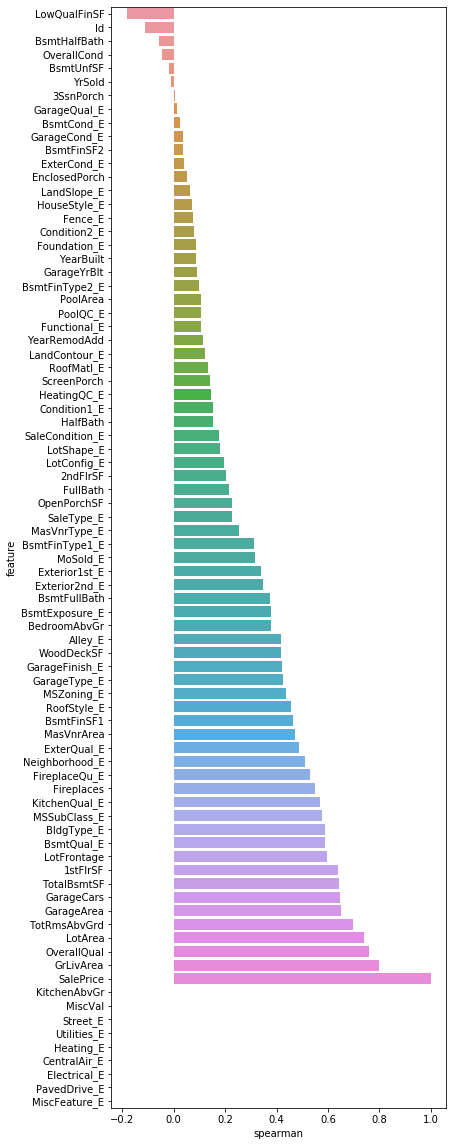

In [64]:
# For expensive houses, LotArea and LotFrontage are distinguishing factors. So are BsmtSF and BsmtQual.

spearman(expensiveWithQualE, 'SalePrice')

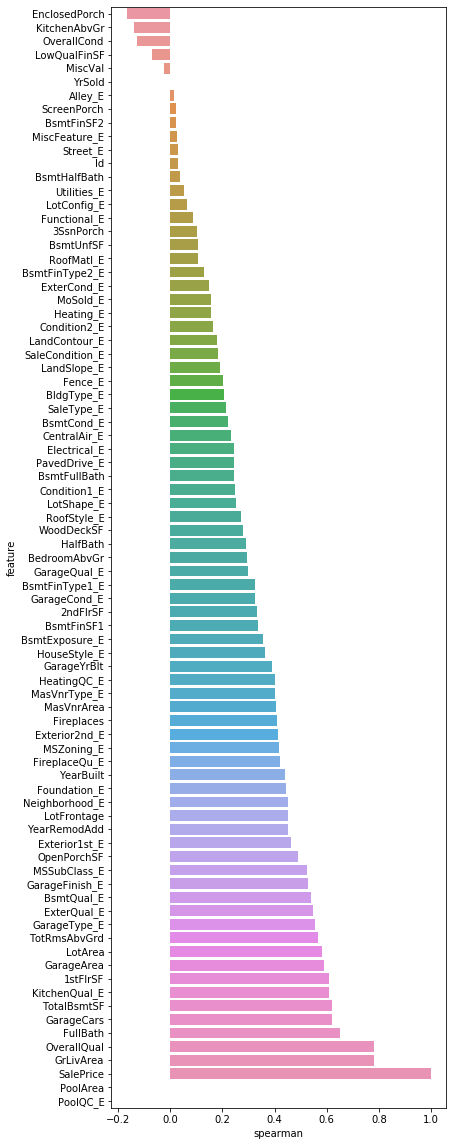

In [65]:
# For Mid-priced homes, number of full baths is a distinguishing factor as is KitchenQual.

spearman(midWithQualE, 'SalePrice')

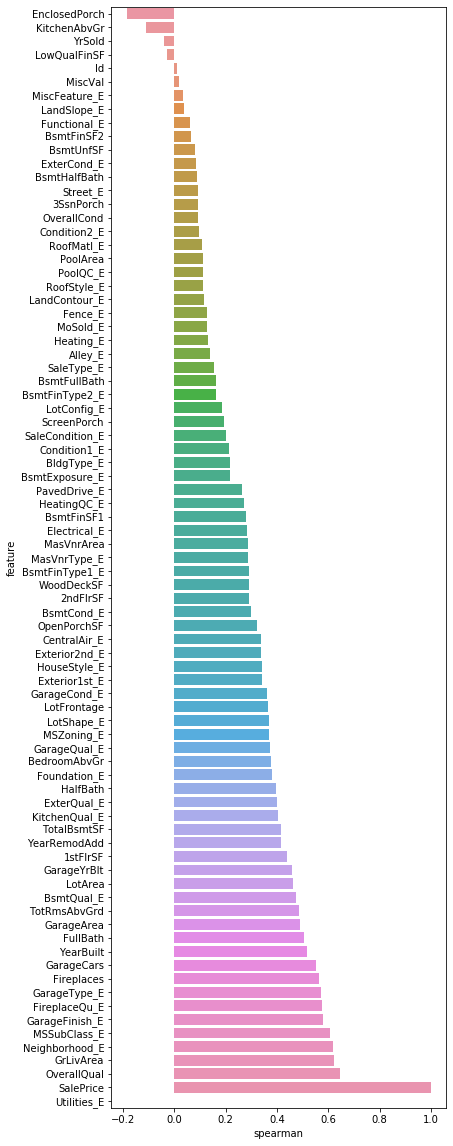

In [66]:
# For Cheap homes, OverallQual is more important than GrLivArea. Neighborhood, fireplaces, and YearBuilt are also
# distinguishing factors.

spearman(cheapWithQualE, 'SalePrice')

Notable Correlations:
OverallQual ,  SalePrice ,  0.7295891647883738
YearBuilt ,  YearRemodAdd ,  0.9058573317766304
YearBuilt ,  GarageYrBlt ,  0.9988914605884179
YearRemodAdd ,  GarageYrBlt ,  0.9063959897225259
BsmtFinSF1 ,  BsmtFullBath ,  0.8067444067446022
TotalBsmtSF ,  1stFlrSF ,  0.9595584578750348
GrLivArea ,  TotRmsAbvGrd ,  0.8100821598281591
GrLivArea ,  SalePrice ,  0.8022882895579097
GarageCars ,  GarageArea ,  0.789027941712463


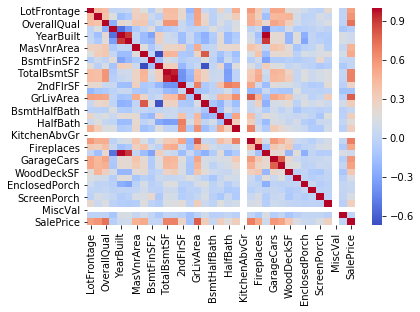

In [67]:
varPearsonCorrHeatMap(expensiveWithQualE, pureQuantVariables, 0.7)

Notable Correlations:
OverallQual ,  SalePrice ,  0.7583095557774181
YearBuilt ,  GarageYrBlt ,  0.8722487523034903
BsmtFinSF1 ,  BsmtFullBath ,  0.7070246221549941
TotalBsmtSF ,  1stFlrSF ,  0.7837024008911873
2ndFlrSF ,  HalfBath ,  0.7033103690392561
GrLivArea ,  TotRmsAbvGrd ,  0.8371115486000853
GrLivArea ,  SalePrice ,  0.7625938748173519
BedroomAbvGr ,  TotRmsAbvGrd ,  0.7253875963755146
GarageCars ,  GarageArea ,  0.8940224336222435


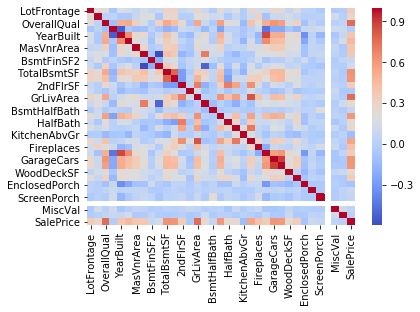

In [68]:
varPearsonCorrHeatMap(midWithQualE, pureQuantVariables, 0.7)

Notable Correlations:
YearBuilt ,  GarageYrBlt ,  0.7350587315804035
TotalBsmtSF ,  1stFlrSF ,  0.737801000204894
GrLivArea ,  TotRmsAbvGrd ,  0.8246429656782689
BedroomAbvGr ,  TotRmsAbvGrd ,  0.7157007900464909
GarageCars ,  GarageArea ,  0.851495094459649


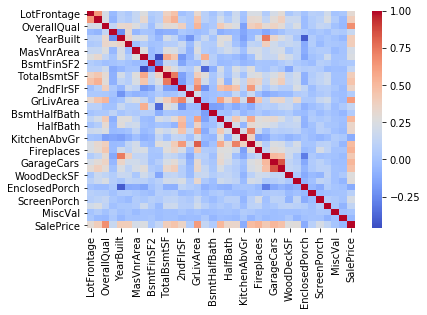

In [69]:
varPearsonCorrHeatMap(cheapWithQualE, pureQuantVariables, 0.7)

Notable Correlations:
MSSubClass_E ,  BldgType_E ,  0.8232842078385229
GarageQual_E ,  GarageCond_E ,  0.7057243619147642
SaleType_E ,  SaleCondition_E ,  0.8795473216407254


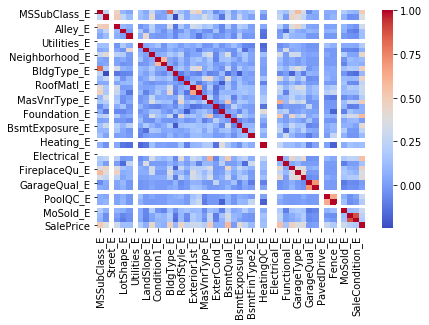

In [70]:
varPearsonCorrHeatMap(expensiveWithQualE, QualEncodedVariables + ['SalePrice'], 0.7)

Notable Correlations:
Exterior1st_E ,  Exterior2nd_E ,  0.8697321973454099
GarageQual_E ,  GarageCond_E ,  0.8912717635265873


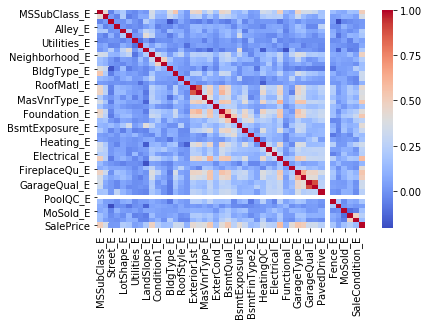

In [71]:
varPearsonCorrHeatMap(midWithQualE, QualEncodedVariables + ['SalePrice'], 0.7)

Notable Correlations:
Exterior1st_E ,  Exterior2nd_E ,  0.8682411280302289
GarageQual_E ,  GarageCond_E ,  0.9209047423596823


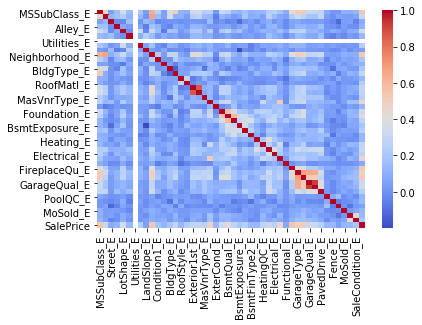

In [72]:
varPearsonCorrHeatMap(cheapWithQualE, QualEncodedVariables + ['SalePrice'], 0.7)

Notable Correlations
LotFrontage ,  BldgType_E ,  0.7020497644936068
OverallQual ,  SalePrice ,  0.729589164788373
2ndFlrSF ,  HouseStyle_E ,  0.887053389646857
GrLivArea ,  SalePrice ,  0.8022882895579094
Fireplaces ,  FireplaceQu_E ,  0.8253490401861782
PoolArea ,  PoolQC_E ,  0.9999999999999977


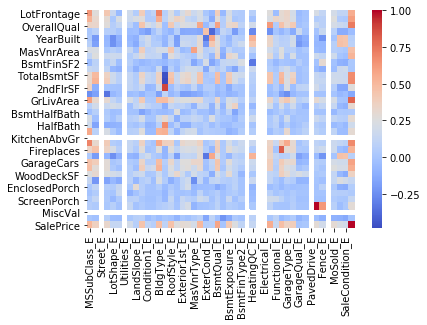

In [73]:
xyVarPearsonCorrHeatMap(expensiveWithQualE, pureQuantVariables, QualEncodedVariables+['SalePrice'], 0.7)

Notable Correlations
OverallQual ,  SalePrice ,  0.7583095557774174
YearBuilt ,  Foundation_E ,  0.7099676408446735
MasVnrArea ,  MasVnrType_E ,  0.7542141996141539
GrLivArea ,  SalePrice ,  0.7625938748173519
Fireplaces ,  FireplaceQu_E ,  0.8320237636636298


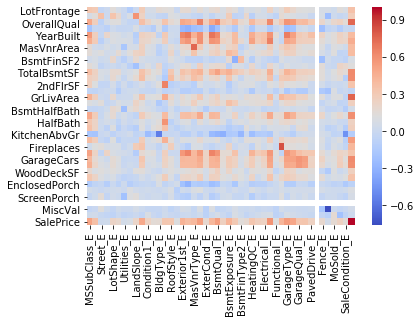

In [74]:
xyVarPearsonCorrHeatMap(midWithQualE, pureQuantVariables, QualEncodedVariables+['SalePrice'], 0.7)

Notable Correlations
MasVnrArea ,  MasVnrType_E ,  0.7239905967567084
Fireplaces ,  FireplaceQu_E ,  0.8703973302098893
PoolArea ,  PoolQC_E ,  0.8820350840879378


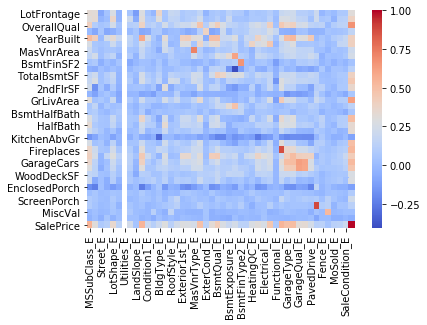

In [75]:
xyVarPearsonCorrHeatMap(cheapWithQualE, pureQuantVariables, QualEncodedVariables+['SalePrice'], 0.7)

In [76]:
# Need to re-encode the qualitiative columns of test according to Expensive, Mid, and Cheap

test = test.drop(columns=QualEncodedVariables)

In [77]:
expensiveTest = test.loc[test['Neighborhood'].isin(ExpensiveNbhds)]
print(expensiveTest.shape)

(265, 80)


In [78]:
midTest = test.loc[test['Neighborhood'].isin(MidNbhds)]
print(midTest.shape)

(343, 80)


In [79]:
cheapTest = test.loc[test['Neighborhood'].isin(CheapNbhds)]
print(cheapTest.shape)

(851, 80)


In [80]:
print(expensiveTest.shape[0] + midTest.shape[0] + cheapTest.shape[0])

1459


In [88]:
def qualMostCommon(frame):
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    neighborhoods = frame['Neighborhood'].unique()
    qualMostCommonDict = {}
    for n in neighborhoods:
        df = frame.loc[frame['Neighborhood'] == n]
        nbhdDict = {}
        for f in qualitative:
            nbhdDict[f] = df[f].value_counts().idxmax()
        qualMostCommonDict[n] = nbhdDict    
    return qualMostCommonDict

qualMostCommonDict = qualMostCommon(train)
print(qualMostCommonDict['NAmes'])

{'MSSubClass': 'SC20', 'MSZoning': 'RL', 'Street': 'Pave', 'Alley': 'None', 'LotShape': 'Reg', 'LandContour': 'Lvl', 'Utilities': 'AllPub', 'LotConfig': 'Inside', 'LandSlope': 'Gtl', 'Neighborhood': 'NAmes', 'Condition1': 'Norm', 'Condition2': 'Norm', 'BldgType': '1Fam', 'HouseStyle': '1Story', 'RoofStyle': 'Gable', 'RoofMatl': 'CompShg', 'Exterior1st': 'MetalSd', 'Exterior2nd': 'MetalSd', 'MasVnrType': 'None', 'ExterQual': 'TA', 'ExterCond': 'TA', 'Foundation': 'CBlock', 'BsmtQual': 'TA', 'BsmtCond': 'TA', 'BsmtExposure': 'No', 'BsmtFinType1': 'BLQ', 'BsmtFinType2': 'Unf', 'Heating': 'GasA', 'HeatingQC': 'TA', 'CentralAir': 'Y', 'Electrical': 'SBrkr', 'KitchenQual': 'TA', 'Functional': 'Typ', 'FireplaceQu': 'None', 'GarageType': 'Attchd', 'GarageFinish': 'Unf', 'GarageQual': 'TA', 'GarageCond': 'TA', 'PavedDrive': 'Y', 'PoolQC': 'None', 'Fence': 'None', 'MiscFeature': 'None', 'MoSold': 'Jul', 'SaleType': 'WD', 'SaleCondition': 'Normal'}


In [89]:
# Re-encode qualitative variables for Expensive, Mid, and Cheap. 
# Sometimes, the test set has categories for features that are not
# encountered in the test set. In this case, replace them with the
# most common value for the neighborhood as we have no information.

def testEncoding(row, fo, feature, qualMostCommonDict):
    if row[feature] in fo[feature].keys():
        answer = fo[feature][row[feature]]
    else:
        mostCommon = qualMostCommonDict[row['Neighborhood']][feature]
        answer = fo[feature][mostCommon]
    return answer

def qualitativeEncodeTest(frame, fo, qualMostCommonDict):
    qualitative = [f for f in frame.columns if frame.dtypes[f] == 'object']
    for feature in qualitative:
        frame[feature + "_E"] = frame.apply(
            lambda row: testEncoding(row, fo, feature, qualMostCommonDict), axis=1)
    return frame    

In [97]:
expensiveWithQualETest = expensiveTest.copy()
expensiveWithQualETest = qualitativeEncodeTest(expensiveWithQualETest, expensiveFO, qualMostCommonDict)
expensiveWithQualETest.head() 

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
4   1465      SC120       RL         43.0     5005   Pave  None      IR1   
15  1476       SC60       RL        102.0    12858   Pave  None      IR1   
16  1477       SC20       RL         94.0    12883   Pave  None      IR1   
17  1478       SC20       RL         90.0    11520   Pave  None      Reg   
18  1479       SC20       RL         79.0    14122   Pave  None      IR1   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
4          HLS    AllPub    Inside       Gtl      StoneBr       Norm   
15         Lvl    AllPub    Inside       Gtl      NridgHt       Norm   
16         Lvl    AllPub    Corner       Gtl      NridgHt       Norm   
17         Lvl    AllPub    Inside       Gtl      NridgHt       PosN   
18         Lvl    AllPub    Inside       Gtl      NridgHt       Norm   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
4        Norm   TwnhsE     1Story            8            5       1992   
15       Norm     1Fam     2Story            9            5       2009   
16       Norm     1Fam     1Story            8            5       2009   
17       Norm     1Fam     1Story            9            5       2005   
18       Norm     1Fam     1Story            8            5       2005   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
4           1992     Gable  CompShg     HdBoard     HdBoard       None   
15          2010     Gable  CompShg     VinylSd     VinylSd      Stone   
16          2010     Gable  CompShg     VinylSd     VinylSd      Stone   
17          2005       Hip  CompShg     VinylSd     VinylSd    BrkFace   
18          2006       Hip  CompShg     CemntBd     CmentBd    BrkFace   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
4          0.0        Gd        TA      PConc       Gd       TA           No   
15       162.0        Ex        TA      PConc       Ex       TA           No   
16       256.0        Gd        TA      PConc       Gd       TA           No   
17       615.0        Gd        TA      PConc       Ex       TA           No   
18       240.0        Gd        TA      PConc       Ex       TA           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
4           ALQ       263.0          Unf         0.0     1017.0       1280.0   
15          Unf         0.0          Unf         0.0     1590.0       1590.0   
16          Unf         0.0          Unf         0.0     1544.0       1544.0   
17          GLQ       110.0          Unf         0.0     1588.0       1698.0   
18          GLQ        28.0          Unf         0.0     1794.0       1822.0   

   Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
4     GasA  ...             3           1           3            1   
15    GasA  ...             1           1           3            1   
16    GasA  ...             1           1           5            1   
17    GasA  ...             1           1           3            1   
18    GasA  ...             1           1           3            1   

    Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
4                4             2             1           2             2   
15               6             2             1           3             3   
16               6             2             1           3             2   
17               6             5             1           3             2   
18               6             2             1           3             2   

    RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
4             1           1              3              4            1   
15            1           1              4              5            2   
16            1           1              4              5            2   
17            2           1              4              5            3   
18            2 

In [98]:
midWithQualETest = midTest.copy()
midWithQualETest = qualitativeEncodeTest(midWithQualETest, midFO, qualMostCommonDict)
midWithQualETest.head() 

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
30  1491       SC60       RL         70.0    11920   Pave  None      Reg   
31  1492       SC30       RH         70.0     9800   Pave  None      Reg   
81  1542       SC50       RM         53.0     5830   Pave  None      Reg   
82  1543       SC75       RL         69.0     7793   Pave  None      IR1   
83  1544       SC30       RM         50.0     5000   Pave  None      Reg   

   LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
30         Lvl    AllPub    Inside       Gtl      SawyerW       Norm   
31         Lvl    AllPub    Corner       Gtl      SawyerW      Feedr   
81         Lvl    AllPub    Corner       Gtl      BrkSide      Feedr   
82         Bnk    AllPub    Corner       Gtl      BrkSide       Norm   
83         Lvl    AllPub    Inside       Gtl      BrkSide      Feedr   

   Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
30       Norm     1Fam     2Story            7            5       2004   
31       Norm     1Fam     1Story            5            5       1920   
81      Feedr     1Fam     1.5Fin            5            6       1950   
82       Norm     1Fam     2.5Unf            7            7       1922   
83       Norm     1Fam     1Story            4            7       1925   

    YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
30          2004     Gable  CompShg     VinylSd     VinylSd    BrkFace   
31          1950     Gable  CompShg     Wd Sdng     Wd Sdng       None   
81          1997     Gable  CompShg     MetalSd     MetalSd       None   
82          2005     Gable  CompShg     Wd Sdng     Wd Sdng       None   
83          1950     Gable  CompShg     MetalSd     MetalSd       None   

    MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
30       122.0        Gd        TA      PConc       Gd       TA           Av   
31         0.0        TA        Fa     BrkTil       TA       TA           No   
81         0.0        TA        Gd     CBlock       TA       TA           No   
82         0.0        TA        TA     BrkTil       Gd       TA           No   
83         0.0        TA        TA     BrkTil       TA       TA           No   

   BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
30          Unf         0.0          Unf         0.0      831.0        831.0   
31          Unf         0.0          Unf         0.0      816.0        816.0   
81          Rec       788.0          Unf         0.0      200.0        988.0   
82          BLQ       474.0          Unf         0.0      634.0       1108.0   
83          Rec       188.0          Unf         0.0      577.0        765.0   

   Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
30    GasA  ...             2           2           4            1   
31    GasA  ...             2           2           3            1   
81    GasA  ...             2           2           3            1   
82    GasA  ...             1           2           3            1   
83    GasA  ...             2           2           4            1   

    Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
30               3             7             4           5             8   
31               3             4             4           5             5   
81               1             4             3           5             3   
82               1             7             4           5             6   
83               1             4             4           5             5   

    RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
30            1           3              8             10            3   
31            1           3              4              5            1   
81            1           3              3              3            1   
82            1           3              4              5            1   
83            1 

In [99]:
cheapWithQualETest = cheapTest.copy()
cheapWithQualETest = qualitativeEncodeTest(cheapWithQualETest, cheapFO, qualMostCommonDict)
cheapWithQualETest.head() 

Id MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461       SC20       RH         80.0    11622   Pave  None      Reg   
1  1462       SC20       RL         81.0    14267   Pave  None      IR1   
2  1463       SC60       RL         74.0    13830   Pave  None      IR1   
3  1464       SC60       RL         78.0     9978   Pave  None      IR1   
5  1466       SC60       RL         75.0    10000   Pave  None      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
5         Lvl    AllPub    Corner       Gtl      Gilbert       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
5       Norm     1Fam     2Story            6            5       1993   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
5          1994     Gable  CompShg     HdBoard     HdBoard       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
5         0.0        TA        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
5          Unf         0.0          Unf         0.0      763.0        763.0   

  Heating  ... LandContour_E Utilities_E LotConfig_E  LandSlope_E  \
0    GasA  ...             3           1           1            3   
1    GasA  ...             3           1           2            3   
2    GasA  ...             3           1           1            3   
3    GasA  ...             3           1           1            3   
5    GasA  ...             3           1           2            3   

   Neighborhood_E  Condition1_E  Condition2_E  BldgType_E  HouseStyle_E  \
0               8             3             5           5             5   
1               8             4             5           5             5   
2              11             4             5           5             7   
3              11             4             5           5             7   
5              11             4             5           5             7   

   RoofStyle_E  RoofMatl_E  Exterior1st_E  Exterior2nd_E MasVnrType_E  \
0            2           2             13             15            1   
1            3           2              9              9            3   
2            2           2             13             15            1   
3            2           2             13             15            3   
5            2           2             11             11            

In [101]:
# Save your Expensive test set for future use

expensiveWithQualETest.to_csv('/home/seasnake/Desktop/Kaggle_Housing/testExpensiveWithQualE.csv', index=False)

In [102]:
# Save your Mid test set for future use

midWithQualETest.to_csv('/home/seasnake/Desktop/Kaggle_Housing/testMidWithQualE.csv', index=False)

In [103]:
# Save your cheap test set for future use

cheapWithQualETest.to_csv('/home/seasnake/Desktop/Kaggle_Housing/testCheapWithQualE.csv', index=False)

In [4]:
quantandqualE = [f for f in train.columns if train.dtypes[f] != 'object']
quantandqualE.remove('SalePrice')
quantandqualE.remove('Id')

In [117]:
expWithQualEQQE = expensiveWithQualE[quantandqualE]
expWithQualEQQE_scaled = StandardScaler().fit_transform(expWithQualEQQE.to_numpy())
expWithQualEQQE_scaled_df = pd.DataFrame(expWithQualEQQE_scaled, columns=quantandqualE)

In [118]:
expWithQualEQQE_scaled_df['GrLivArea'].describe()

count    2.570000e+02
mean     3.542346e-17
std      1.001951e+00
min     -1.441316e+00
25%     -7.052921e-01
50%     -2.542415e-01
75%      4.931060e-01
max      4.952657e+00
Name: GrLivArea, dtype: float64

In [120]:
from sklearn.preprocessing import RobustScaler

expWithQualEQQE_scaled_r = RobustScaler().fit_transform(expWithQualEQQE.to_numpy())
expWithQualEQQE_scaled_r_df = pd.DataFrame(expWithQualEQQE_scaled_r, columns=quantandqualE)
expWithQualEQQE_scaled_r_df['GrLivArea'].describe()

count    257.000000
mean       0.212151
std        0.836075
min       -0.990551
25%       -0.376378
50%        0.000000
75%        0.623622
max        4.344882
Name: GrLivArea, dtype: float64

In [42]:
def featureSelection(frame, target_col, spThreshold, corrThreshold):
    features = [f for f in frame.columns if frame.dtypes[f] != object]
    features.remove('Id')
    corr = frame[features].corr()
    corrWSP = corr['SalePrice']
    corrWSP = corrWSP.sort_values(ascending=False)
    corrWSP = corrWSP[abs(corrWSP) > spThreshold]
    sortedFeatures = corrWSP.index[1:] # remove SalePrice
    featureSelection = []
    featureSelection.append(sortedFeatures[0]) # loop won't work for first feature
    for i in range(len(sortedFeatures)):
        for j in range(i):
            if corr.loc[sortedFeatures[i]][sortedFeatures[j]] > corrThreshold:
                break
            if j == i-1:
                featureSelection.append(sortedFeatures[i])
    return featureSelection

In [43]:
featureSelectionExp = featureSelection(expensiveWithQualE, 'SalePrice', 0.2, 0.7)
print(featureSelectionExp)

['GrLivArea', 'OverallQual', '1stFlrSF', 'LotArea', 'GarageCars', 'BsmtQual_E', 'KitchenQual_E', 'LotFrontage', 'Fireplaces', 'BsmtFinSF1', 'MSSubClass_E', 'ExterQual_E', 'MasVnrArea', 'RoofStyle_E', 'Neighborhood_E', 'BsmtExposure_E', 'GarageFinish_E', 'MSZoning_E', 'GarageType_E', 'WoodDeckSF', 'Alley_E', 'FullBath', 'BedroomAbvGr', 'Exterior1st_E', 'MoSold_E', 'PoolQC_E', 'Exterior2nd_E', '2ndFlrSF', 'RoofMatl_E', 'BsmtFinType1_E', 'SaleType_E', 'MasVnrType_E']


In [44]:
featureSelectionMid = featureSelection(midWithQualE, 'SalePrice', 0.2, 0.7)
print(featureSelectionMid)

['GrLivArea', 'OverallQual', 'TotalBsmtSF', 'GarageCars', 'FullBath', 'KitchenQual_E', 'GarageType_E', 'BsmtQual_E', 'ExterQual_E', 'MSSubClass_E', 'GarageFinish_E', 'Neighborhood_E', 'YearRemodAdd', 'Exterior1st_E', 'BsmtExposure_E', 'FireplaceQu_E', 'Foundation_E', 'MasVnrType_E', 'BsmtFinSF1', 'MSZoning_E', 'LotFrontage', 'OpenPorchSF', '2ndFlrSF', 'GarageCond_E', 'HeatingQC_E', 'HouseStyle_E', 'RoofStyle_E', 'BsmtFinType1_E', 'LotArea', 'CentralAir_E', 'BsmtCond_E', 'WoodDeckSF', 'PavedDrive_E', 'SaleType_E', 'Condition1_E', 'Electrical_E', 'LotShape_E', 'LandSlope_E']


In [5]:
def myPCA(frame, features):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(frame[features].to_numpy())
    pca = PCA().fit(X_train_scaled)
    return pca

In [8]:
pca1 = myPCA(train, quantandqualE)
components = pca1.components_
df = pd.DataFrame(data=components, columns=quantandqualE)
df.head()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
0     0.081044  0.048273     0.213056    -0.053974   0.210367      0.172653   
1     0.180522  0.150593     0.069066     0.005849  -0.166907     -0.088929   
2     0.138884  0.210452    -0.034273     0.051739  -0.064508     -0.117769   
3     0.015572  0.000634     0.077581    -0.105602  -0.000325      0.073748   
4     0.039032  0.010606    -0.076229    -0.279598   0.131351     -0.076623   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  1stFlrSF  \
0    0.118702    0.093329   -0.010990   0.069315     0.162802  0.140337   
1    0.099756   -0.005879    0.013109   0.073669     0.072908  0.169821   
2    0.038623    0.319513    0.170141  -0.181194     0.212244  0.241573   
3    0.053016    0.069238   -0.114810   0.216914     0.248243  0.197516   
4    0.074753   -0.034393    0.008017   0.029728    -0.002866  0.134638   

   2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  \
0  0.061852     -0.027878   0.152046      0.057920     -0.005068  0.158955   
1  0.266195      0.104904   0.355776     -0.063088      0.006888  0.169519   
2 -0.264581     -0.023650  -0.044260      0.272552      0.067839 -0.157010   
3 -0.199581      0.038555  -0.016920      0.079296     -0.079246  0.044765   
4 -0.182913     -0.117629  -0.063783     -0.040395     -0.070512  0.092217   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0  0.084558      0.026197     -0.055824      0.108688    0.110635   
1  0.103919      0.314907      0.183972      0.366440    0.177380   
2 -0.173788     -0.135832     -0.082002     -0.115152    0.158825   
3 -0.232183     -0.122837      0.106312     -0.026910   -0.065649   
4 -0.143138     -0.014221      0.267317     -0.002558   -0.086186   

   GarageYrBlt  GarageCars  GarageArea  WoodDeckSF  OpenPorchSF  \
0     0.202621    0.195658    0.185565    0.088681     0.088355   
1    -0.148544    0.045733    0.055698    0.032203     0.085613   
2    -0.079233    0.031195    0.079731    0.099332    -0.046421   
3    -0.016081   -0.061735   -0.040712   -0.020162     0.039172   
4     0.120127    0.146368    0.144030   -0.061304    -0.082714   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea   MiscVal    YrSold  \
0      -0.069292   0.012559     0.013410  0.018691 -0.011258 -0.006941   
1       0.104815  -0.008417     0.067771  0.117371  0.029544 -0.025848   
2       0.013755   0.020012     0.094293  0.102169  0.025325  0.014192   
3       0.038178  -0.005084    -0.069538 -0.020804 -0.030620 -0.017706   
4      -0.110933   0.029610    -0.069007 -0.140572  0.004379  0.053525   

   MSSubClass_E  MSZoning_E  Street_E   Alley_E  LotShape_E  LandContour_E  \
0      0.177051    0.114838  0.010909  0.042694    0.077557       0.041382   
1     -0.028887   -0.026926 -0.008489 -0.071187    0.040491      -0.028947   
2     -0.061640    0.034489 -0.078243 -0.031678    0.074608       0.087025   
3     -0.220086   -0.109927 -0.028807 -0.041512   -0.062677       0.019093   
4     -0.014316    0.128494 -0.020885  0.051334   -0.050288       0.012868   

   Utilities_E  LotConfig_E  LandSlope_E  Neighborhood_E  Condition1_E  \
0     0.000975     0.035707    -0.003562        0.204167      0.061179   
1    -0.010527     0.014763     0.038997       -0.017172     -0.042260   
2    -0.021436     0.068542     0.140702       -0.012447      0.001960   
3     0.029039    -0.061178     0.001354        0.032659     -0.029788   
4    -0.008921    -0.029485    -0.065137        0.072272      0.013213   

   Condition2_E  BldgType_E  HouseStyle_E  RoofStyle_E  RoofMatl_E  \
0      0.032183    0.072103      0.109131     0.045615    0.017838   
1      0.022577   -0.182697      0.043062     0.072962    0.052398   
2      0.000017    0.038450     -0.177309     0.187701    0.100270   
3      0.008485   -0.094633     -0.191687     0.053016   -0.007196   
4     -0.000113   -0.191984     -0.031048     0.073783   -0.061970   

   Exterio

Text(0, 0.5, 'Explained Variance')

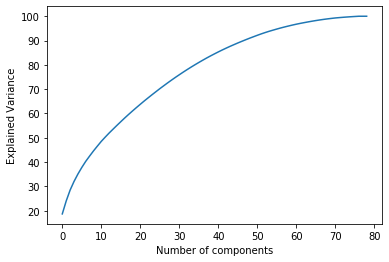

In [11]:
plt.plot(np.cumsum(pca1.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')

In [12]:
print(np.cumsum(pca1.explained_variance_ratio_ * 100))

[ 18.66656271  23.97580589  28.44849734  32.00400258  35.06063162
  37.78501796  40.28044216  42.47155772  44.59605183  46.58493428
  48.5287165   50.26331528  51.94319581  53.52538207  55.09255115
  56.6242826   58.14454278  59.60936472  61.0315169   62.42702192
  63.78835965  65.13773899  66.4310803   67.71236876  68.95999428
  70.20749272  71.39983676  72.58444178  73.73262861  74.85800546
  75.94318308  77.01740361  78.05417973  79.06423854  80.04009939
  80.99207242  81.91783334  82.8208688   83.68419848  84.51986179
  85.33702836  86.12712245  86.88238789  87.61961466  88.31824257
  89.01337811  89.67383334  90.32852246  90.96297683  91.57042594
  92.17142606  92.75090082  93.29388486  93.80551868  94.28014218
  94.74048964  95.18880376  95.60227839  95.99633836  96.37957799
  96.73612374  97.0667663   97.37497691  97.67351655  97.95988115
  98.2294075   98.47813658  98.71121436  98.92310359  99.11469147
  99.29913018  99.43983659  99.57283531  99.69044753  99.8030526
  99.902616